In [0]:
import pandas as pd
import requests
import numpy as np
from sklearn.decomposition import FastICA
from io import StringIO
from scipy import signal
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

#Datos cargados desde drive
orig_url='https://drive.google.com/file/d/1lPNRzlmfm0iT-HV8mLCIdzvt3zNpu5nN/view?usp=sharing'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
sp500 = pd.read_csv(csv_raw)

# Muestra de 
#probar de muestras atras
d = sp500.close.iloc[-366:-1].to_numpy().reshape(-1,1)
u1 = sp500.close.iloc[-367:-2].to_numpy().reshape(-1,1)
u2 = sp500.close.iloc[-368:-3].to_numpy().reshape(-1,1)
u3 = sp500.close.iloc[-369:-4].to_numpy().reshape(-1,1)
u4 = sp500.close.iloc[-370:-5].to_numpy().reshape(-1,1)
u5 = sp500.close.iloc[-371:-6].to_numpy().reshape(-1,1)
u = np.concatenate((u1,u2,u3,u4,u5), axis=1)
# plt.figure(figsize=(18, 6))
# print(u.shape)
# plt.plot(u)
# plt.grid()
# plt.show()

In [0]:
class QKLMS:
  def __init__(self, eta=0.9, epsilon=10, sigma=22):
    self.eta = eta
    self.epsilon = epsilon
    self.sigma = sigma
    self.CB = []
    self.a_coef = []
    self.CB_growth = []   
    
  def evaluate(self, u , d):
    if u.shape[0]!=d.shape[0]:
      raise ValueError('All of the input arguments must be of the same lenght')

    #Inicializacion de Codebook y coeficientes a
    self.CB.append(u[0,:])
    self.a_coef.append(self.eta*d[0,:])
    #Tamaños
    N,D = u.shape
    Nd,Dd = d.shape
    y = np.empty((Nd,Dd))
    i = 1
    err = 0.1;
    #Signa por regla de Silverman
    # self.__optimalSigma(u)

    while True:
      yi,disti = self.__output(u[i,:].reshape(-1,D)) #Salida
      # d_mahal = self.__dmahal(u[i,:].reshape(-1,D)) #Distancia de Mahalanobis
      # self.__newEta(yi,err) #Nuevo eta
      err = d[i] - yi # Error
      #Cuantizacion
      min_index = np.argmin(disti)
      if disti[min_index] <= self.epsilon:
        self.a_coef[min_index] =(self.a_coef[min_index] + self.eta*err).item()
      else:
        self.CB.append(u[i,:])
        self.a_coef.append((self.eta*err).item())
    
      y[i-1] = yi
      i+=1      
      if(i == N-1):
        return y

  def __output(self,ui):
    from scipy.spatial.distance import cdist
    dist = cdist(np.asarray(self.CB), ui)
    K = np.exp(-0.5*(dist**2)/(self.sigma**2))
    y = K.T.dot(np.asarray(self.a_coef))
    return [y,dist]

  def __newEta(self, y, errp):
    # y: Salida calculada
    # errp: Error a priori 
    self.eta = (2*errp*y)/(errp**2 + 1)
    return False

  def __dmahal(self,ui): 
    # print(np.asarray(self.CB).shape, ui.shape)
    # print("CB:",np.asarray(self.CB).shape)
    # print("Ui:", ui.shape)
    dist_m = cdist(np.asarray(self.CB), ui, metric='mahalanobis')
    return dist_m

  def __optimalSigma(self, u):
    N_total, dims= u.shape
    stdDev = np.std(u)
    self.sigma = stdDev*(4/(N_total*(2*dims+1)))**(1/dims+4)
    return False

    

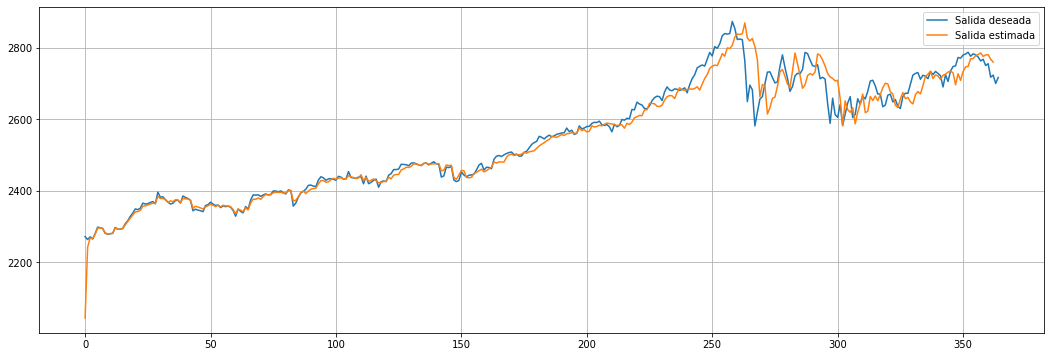

In [0]:
import numpy as np
qklms = QKLMS(sigma=1000)
y = qklms.evaluate(u,d)
plt.figure(figsize=(18, 6))
plt.grid()
plt.plot(d, label="Salida deseada")
plt.plot(y[:-2], label="Salida estimada")
plt.legend()

a size:  (326,)
CB size:  (326, 5)


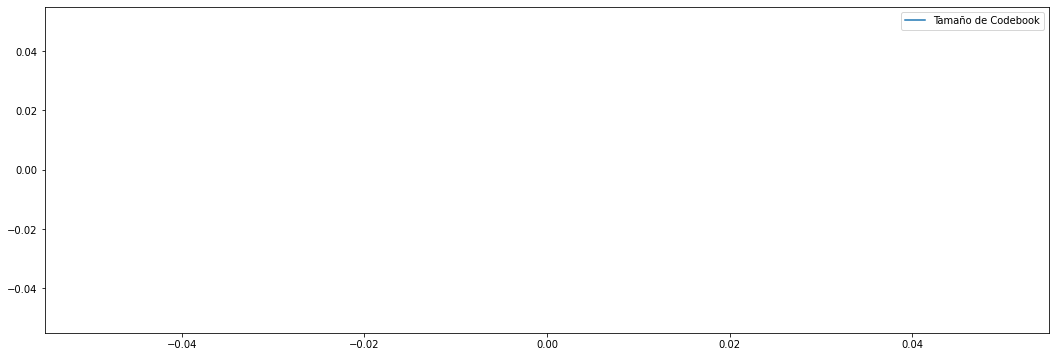

In [0]:
  plt.figure(figsize=(18, 6))
plt.plot(np.asarray(qklms.CB_growth), label="Tamaño de Codebook")
plt.legend()
print("a size: ", np.asarray(qklms.a_coef).shape)
print("CB size: ", np.asarray(qklms.CB).shape)

In [0]:
plt.imshow()

TypeError: ignored

In [0]:
samplesNumber, dimensionality = u.shape
stdDev = np.std(u)
N_total = samplesNumber
dims = 2
OptSgm = stdDev*((4/(N_total*2*dims+1))**(1/dims+4)) 
OptSgm

In [0]:
((2*dims+1)**-1)

In [0]:
ax = np.random.rand(5,5)
ab = np.random.rand(1,5)
print("ax shape", ax.shape, "y ab shape ",ab.shape)

dist = cdist(ax,ab,'mahalanobis')
dist.shape

ax shape (5, 5) y ab shape  (1, 5)


(5, 1)

In [0]:
asd = ax-ab
asd.shape


In [0]:
12/4/3